In [1]:
#from pandas import read_csv
from pandas import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

<ipython-input-1-dfda4ad542f4>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
from warnings import simplefilter
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression   
from sktime.datasets import load_airline
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
#     ReducedRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series
simplefilter("ignore", FutureWarning)
%matplotlib inline

# EPS and STD predictions
- we will first have to predict the earnings of the companies using linear regression since 
1. Analyst estimates data for the stocks in the study period was not available from a reliable source.
2. Using a time series model like ARIMA: ARIMA model can be used to predict earnings based on previous earnings, only when the time series formed from previous lagged earnings is stationary(without trend and seasonality). In our case, the series was not stationary, hence ARIMA could not be used.

## Data preprocessing

In [3]:
fundamentals = pd.read_csv('../dataset/fundamentals_filtered.csv')


In [5]:
fundamentals_list = fundamentals['ticker'].unique().tolist()

In [6]:
# we want only the epsusd, calendar and Ticker columns left
data = pd.DataFrame()

In [7]:
data.dtypes

Series([], dtype: object)

In [8]:
# read them into the data dataframe
data['ticker'] = fundamentals['ticker']
data['date'] = fundamentals['calendardate']
data['eps'] = fundamentals['epsusd']


In [9]:
data

,ticker,date,eps
0,ZSAN,2020-09-30,-0.11
1,ZSAN,2020-06-30,-0.14
2,ZSAN,2020-03-31,-0.24
3,ZSAN,2019-12-31,-0.45
4,ZSAN,2019-09-30,-0.55
...,...,...,...
19384,AAME,2016-03-31,0.04
19385,AAME,2015-12-31,0.00
19386,AAME,2015-09-30,0.01
19387,AAME,2015-06-30,0.16


In [10]:
#save the quarter dates into column_name
column_name = data['date'].unique().tolist()
column_name

['2020-09-30',
 '2020-06-30',
 '2020-03-31',
 '2019-12-31',
 '2019-09-30',
 '2019-06-30',
 '2019-03-31',
 '2018-12-31',
 '2018-09-30',
 '2018-06-30',
 '2018-03-31',
 '2017-12-31',
 '2017-09-30',
 '2017-06-30',
 '2017-03-31',
 '2016-12-31',
 '2016-09-30',
 '2016-06-30',
 '2016-03-31',
 '2015-12-31',
 '2015-09-30',
 '2015-06-30',
 '2015-03-31']

In [11]:
#save the Ticker
Ticker = data['ticker'].unique()
len(Ticker)


843

In [12]:
data_ticker = data['ticker'].unique()
data_ticker = data_ticker.tolist()
data_ticker

['ZSAN',
 'ZNOG',
 'ZIVO',
 'ZGNX',
 'ZEUS',
 'ZAGG',
 'YEWB',
 'XXII',
 'XTNT',
 'XSPA',
 'XONE',
 'XENE',
 'XELB',
 'WYY',
 'WWR',
 'WVVI',
 'WVFC',
 'WTT',
 'WSTL',
 'WSTG',
 'WNEB',
 'WLFC',
 'WLDN',
 'WHLR',
 'WHLM',
 'WHF',
 'WDDD',
 'WATT',
 'VXRT',
 'VUZI',
 'VTNR',
 'VPG',
 'VOXX',
 'VNRX',
 'VIVE',
 'VIRC',
 'VIDE',
 'VGZ',
 'VERU',
 'VEC',
 'VCYT',
 'VCRA',
 'VCEL',
 'VBTX',
 'VBFC',
 'VASO',
 'VALU',
 'VABK',
 'UWHR',
 'UUU',
 'UTI',
 'USNU',
 'USIO',
 'USAP',
 'USAK',
 'URG',
 'UPLD',
 'UONE',
 'UNB',
 'UNAM',
 'UMH',
 'ULBI',
 'UG',
 'UFPT',
 'UEC',
 'UCTT',
 'UBOH',
 'UBFO',
 'UBCP',
 'UAMY',
 'TZOO',
 'TWIN',
 'TSRI',
 'TSQ',
 'TSBK',
 'TRXC',
 'TRVN',
 'TRUP',
 'TRNS',
 'TPVG',
 'TPCS',
 'TOMZ',
 'TOFB',
 'TNXP',
 'TNLX',
 'TMQ',
 'TMBR',
 'TLYS',
 'TKOI',
 'TIPT',
 'TIKK',
 'THMO',
 'THM',
 'TGLS',
 'TGHI',
 'TGEN',
 'TGC',
 'TESS',
 'TENX',
 'TELL',
 'TCON',
 'TCI',
 'TCFC',
 'TBK',
 'TAYD',
 'TAT',
 'TAIT',
 'TACO',
 'SYNL',
 'SYNC',
 'SYN',
 'SWKH',
 'SVT',
 'SVBI'

In [13]:
#dataframe for stocks eps
tickers = data_ticker
stocks_eps = (
    (pd.concat(
        [pd.read_csv(f"../dataset/eps/{ticker}.csv")[
            'eps'
        ].rename(ticker)
        for ticker in tickers],
        axis=1,
        sort=True)
    )
)

stocks_eps  = stocks_eps.loc[:,~stocks_eps.columns.duplicated()]

In [14]:
stocks_eps['date'] = pd.DataFrame(column_name)

In [15]:
stocks_eps_list = stocks_eps.columns.to_list()

In [16]:
original_date = list(data.date.unique())
original_date

['2020-09-30',
 '2020-06-30',
 '2020-03-31',
 '2019-12-31',
 '2019-09-30',
 '2019-06-30',
 '2019-03-31',
 '2018-12-31',
 '2018-09-30',
 '2018-06-30',
 '2018-03-31',
 '2017-12-31',
 '2017-09-30',
 '2017-06-30',
 '2017-03-31',
 '2016-12-31',
 '2016-09-30',
 '2016-06-30',
 '2016-03-31',
 '2015-12-31',
 '2015-09-30',
 '2015-06-30',
 '2015-03-31']

In [17]:
#set date as the index
stocks_eps.set_index('date')

,ZSAN,ZNOG,ZIVO,ZGNX,ZEUS,ZAGG,YEWB,XXII,XTNT,XSPA,...,ACRX,ACNB,ACHV,ACFN,ACER,ABMC,ABIO,ABEO,ABCP,AAME
date,,,,,,,,,,,,,,,,,,,,,
2020-09-30,-0.11,-0.01,-0.01,-1.08,-0.13,0.21,0.02,-0.03,-0.100,-0.100,...,-0.10,0.79,-1.140,0.00,-0.510,-0.01,-0.330,-0.08,-0.04,0.09
2020-06-30,-0.14,-0.01,0.00,-0.96,-0.56,-0.11,0.01,-0.04,-0.190,-1.510,...,-0.08,0.67,-1.680,0.00,-0.560,0.00,-0.730,-0.14,-0.02,0.31
2020-03-31,-0.24,-0.01,-0.01,-0.54,0.05,-2.54,0.00,-0.03,-0.190,-1.740,...,-0.20,-0.14,-2.200,-0.01,-0.490,-0.01,-0.830,-0.52,-0.03,-0.40
2019-12-31,-0.45,-0.01,-0.01,-1.20,-0.07,0.86,-0.04,-0.05,-0.130,6.000,...,-0.18,0.72,-3.800,0.00,-0.510,-0.01,-0.690,-0.29,-0.02,0.06
2019-09-30,-0.55,-0.02,-0.01,-6.75,0.05,0.30,0.02,-0.08,-0.140,-5.040,...,-0.16,0.89,-9.000,0.00,-0.520,0.00,-0.760,-0.35,-0.03,-0.07
2019-06-30,-0.55,-0.02,-0.01,-0.89,0.18,-0.18,0.03,-0.06,-0.150,-9.660,...,-0.16,0.92,-10.000,-0.01,-1.090,0.00,-1.140,-0.49,-0.05,-0.22
2019-03-31,-0.79,-0.03,-0.02,-0.83,0.18,-0.50,0.01,-0.02,-0.210,-4.830,...,-0.17,0.83,-17.600,-0.01,-0.790,-0.01,-1.860,-0.39,-0.02,0.20
2018-12-31,-0.81,-0.52,-0.01,-0.49,-0.12,0.52,-0.06,-0.07,-4.780,-9.600,...,-0.17,0.75,1.800,-0.01,-0.900,-0.01,-1.800,-0.42,0.02,0.01
2018-09-30,-0.68,0.02,-0.03,-1.08,1.01,0.52,-0.01,0.05,-0.240,-6.600,...,-0.21,0.86,-14.200,0.00,-0.430,-0.01,-1.980,-0.34,-0.02,0.04


In [18]:
# check for nulls
print(stocks_eps.isnull().sum().sum())
null = pd.DataFrame(stocks_eps.isnull().sum())
null

52


,0
ZSAN,0
ZNOG,0
ZIVO,0
ZGNX,0
ZEUS,0
...,...
ABIO,0
ABEO,0
ABCP,0
AAME,0


In [19]:
#backfill the null with ffill because we are assuming that we do not know the next data, so we can't use bfill
stocks_eps = stocks_eps.fillna(method='ffill')

In [20]:
stocks_eps.isnull().sum().sum()

7

In [21]:
nan_cols = [i for i in stocks_eps.columns if stocks_eps[i].isnull().any()]
nan_cols

['SRGZ', 'MATN', 'ARTW']

In [22]:
#the remaining Na we will do a backfill since it doesn't really affect the result much
stocks_eps = stocks_eps.fillna(method='bfill')
stocks_eps.isnull().sum().sum()

0

## Transforming the dataframe


In [24]:
df = stocks_eps

print(df.dtypes)
# we want to make the column into the index and index into the column
df_transposed = df.drop(['date'], axis =1).transpose()
df_transposed
# print(df_transposed.dtypes)

# set date as column name 
# df_transposed = df_transposed.rename(columns=df_transposed.iloc[-1]).drop(['date'])

#remove ticker as index
df_transposed.reset_index(inplace=True)

#rename index as Ticker
df_transposed.rename(columns ={'index': 'Ticker'}, inplace=True)

# this df is for actual eps
# df_transposed = pd.concat([df.date, df_transposed], axis = 1)
df_transposed.columns = ['Ticker' , *df.date]
# print(df_transposed.dtypes)


ZSAN    float64
ZNOG    float64
ZIVO    float64
ZGNX    float64
ZEUS    float64
         ...   
ABIO    float64
ABEO    float64
ABCP    float64
AAME    float64
date     object
Length: 844, dtype: object
0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
18    float64
19    float64
20    float64
21    float64
22    float64
dtype: object
Ticker         object
2020-09-30    float64
2020-06-30    float64
2020-03-31    float64
2019-12-31    float64
2019-09-30    float64
2019-06-30    float64
2019-03-31    float64
2018-12-31    float64
2018-09-30    float64
2018-06-30    float64
2018-03-31    float64
2017-12-31    float64
2017-09-30    float64
2017-06-30    float64
2017-03-31    float64
2016-12-31    float64
2016-09-30    float64
2016-06-30    float64
2016-03-31    float64
2015-12-31    float64

In [26]:
df
df_transposed

,Ticker,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,...,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31
0,ZSAN,-0.11,-0.14,-0.24,-0.45,-0.55,-0.55,-0.79,-0.81,-0.68,...,-3.400,-6.800,-8.800,-10.400,-10.800,-13.600,-12.80,-14.40,-12.600,-9.400
1,ZNOG,-0.01,-0.01,-0.01,-0.01,-0.02,-0.02,-0.03,-0.52,0.02,...,-0.100,-0.070,-0.040,-0.040,-0.080,-0.040,-0.02,-0.05,-0.060,-0.070
2,ZIVO,-0.01,0.00,-0.01,-0.01,-0.01,-0.01,-0.02,-0.01,-0.03,...,-0.010,-0.010,-0.010,-0.010,-0.020,-0.010,0.00,-0.01,-0.020,-0.010
3,ZGNX,-1.08,-0.96,-0.54,-1.20,-6.75,-0.89,-0.83,-0.49,-1.08,...,-0.930,-0.860,-0.940,-0.690,-0.760,-0.420,-0.50,-0.65,3.780,-1.200
4,ZEUS,-0.13,-0.56,0.05,-0.07,0.05,0.18,0.18,-0.12,1.01,...,0.420,0.680,-0.190,-0.160,0.320,-0.070,-0.44,-0.05,-1.990,0.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,ABMC,-0.01,0.00,-0.01,-0.01,0.00,0.00,-0.01,-0.01,-0.01,...,-0.010,0.000,0.000,-0.010,0.000,0.000,-0.01,0.00,-0.010,0.000
839,ABIO,-0.33,-0.73,-0.83,-0.69,-0.76,-1.14,-1.86,-1.80,-1.98,...,-10.619,-8.639,-8.279,-9.179,-7.739,-7.199,-5.04,-5.58,-12.599,-16.378
840,ABEO,-0.08,-0.14,-0.52,-0.29,-0.35,-0.49,-0.39,-0.42,-0.34,...,-0.210,-0.130,-0.190,-0.080,-0.200,-0.170,-0.06,-0.19,-0.160,-0.100
841,ABCP,-0.04,-0.02,-0.03,-0.02,-0.03,-0.05,-0.02,0.02,-0.02,...,-0.030,-0.030,-0.010,-0.020,-0.020,-0.030,-0.02,-0.04,-0.030,-0.030


In [28]:
# rename the column names
# names = ['Ticker', 'Sep-20', 'Jun-20', 'Mar-20', 
#          'Dec-19', 'Sep-19', 'Jun-19','Mar-19', 
#          'Dec-18', 'Sep-18', 'Jun-18', 'Mar-18', 
#          'Dec-17', 'Sep-17','Jun-17', 'Mar-17', 
#          'Dec-16', 'Sep-16', 'Jun-16', 'Mar-16', 
#          'Dec-15','Sep-15', 'Jun-15', 'Mar-15']
# df_transposed = df_transposed.rename(columns=dict(zip(df_transposed.columns,names)))

df_transposed


,Ticker,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,...,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31
0,ZSAN,-0.11,-0.14,-0.24,-0.45,-0.55,-0.55,-0.79,-0.81,-0.68,...,-3.400,-6.800,-8.800,-10.400,-10.800,-13.600,-12.80,-14.40,-12.600,-9.400
1,ZNOG,-0.01,-0.01,-0.01,-0.01,-0.02,-0.02,-0.03,-0.52,0.02,...,-0.100,-0.070,-0.040,-0.040,-0.080,-0.040,-0.02,-0.05,-0.060,-0.070
2,ZIVO,-0.01,0.00,-0.01,-0.01,-0.01,-0.01,-0.02,-0.01,-0.03,...,-0.010,-0.010,-0.010,-0.010,-0.020,-0.010,0.00,-0.01,-0.020,-0.010
3,ZGNX,-1.08,-0.96,-0.54,-1.20,-6.75,-0.89,-0.83,-0.49,-1.08,...,-0.930,-0.860,-0.940,-0.690,-0.760,-0.420,-0.50,-0.65,3.780,-1.200
4,ZEUS,-0.13,-0.56,0.05,-0.07,0.05,0.18,0.18,-0.12,1.01,...,0.420,0.680,-0.190,-0.160,0.320,-0.070,-0.44,-0.05,-1.990,0.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,ABMC,-0.01,0.00,-0.01,-0.01,0.00,0.00,-0.01,-0.01,-0.01,...,-0.010,0.000,0.000,-0.010,0.000,0.000,-0.01,0.00,-0.010,0.000
839,ABIO,-0.33,-0.73,-0.83,-0.69,-0.76,-1.14,-1.86,-1.80,-1.98,...,-10.619,-8.639,-8.279,-9.179,-7.739,-7.199,-5.04,-5.58,-12.599,-16.378
840,ABEO,-0.08,-0.14,-0.52,-0.29,-0.35,-0.49,-0.39,-0.42,-0.34,...,-0.210,-0.130,-0.190,-0.080,-0.200,-0.170,-0.06,-0.19,-0.160,-0.100
841,ABCP,-0.04,-0.02,-0.03,-0.02,-0.03,-0.05,-0.02,0.02,-0.02,...,-0.030,-0.030,-0.010,-0.020,-0.020,-0.030,-0.02,-0.04,-0.030,-0.030


# Using functions

In [29]:
def transpose_reverse(data):
    Ticker = data.Ticker.str.replace(' IS Equity','')
    df = data.iloc[::,1:]
    df = df.iloc[:,::-1].T
#     df.columns = Ticker
    df = df.reset_index()
    df['index'] = df['index'].str.replace('-',' 20')
#     df['index'] = pd.to_datetime(df['index'])
    df = df.set_index('index')#.asfreq('Q')
    df.columns = Ticker

    return df

In [30]:
df = transpose_reverse(df_transposed)
df.head()

Ticker,ZSAN,ZNOG,ZIVO,ZGNX,ZEUS,ZAGG,YEWB,XXII,XTNT,XSPA,...,ACRX,ACNB,ACHV,ACFN,ACER,ABMC,ABIO,ABEO,ABCP,AAME
index,,,,,,,,,,,,,,,,,,,,,
2015 2003 2031,-9.4,-0.07,-0.01,-1.20,0.10,0.11,0.02,-0.06,-7.440,-42.000,...,-0.23,0.42,-439.996,-0.11,-9.936,0.00,-16.378,-0.10,-0.03,0.03
2015 2006 2030,-12.6,-0.06,-0.02,3.78,-1.99,0.13,0.04,-0.02,-4.920,-54.001,...,-0.20,0.47,-571.994,-0.12,-5.796,-0.01,-12.599,-0.16,-0.03,0.16
2015 2009 2030,-14.4,-0.05,-0.01,-0.65,-0.05,0.13,0.02,-0.04,-7.680,-72.001,...,0.11,0.47,-351.996,-0.10,-4.347,0.00,-5.580,-0.19,-0.04,0.01
2015 2012 2031,-12.8,-0.02,0.00,-0.50,-0.44,0.18,0.03,-0.04,17.521,102.601,...,-0.24,0.47,-87.999,-0.07,-3.105,-0.01,-5.040,-0.06,-0.02,0.00
2016 2003 2031,-13.6,-0.04,-0.01,-0.42,-0.07,-0.12,0.02,-0.04,-5.640,-16.800,...,-0.24,0.42,-263.997,-0.11,-3.208,0.00,-7.199,-0.17,-0.03,0.04


In [32]:
original_date.reverse()
original_date

['2015-03-31',
 '2015-06-30',
 '2015-09-30',
 '2015-12-31',
 '2016-03-31',
 '2016-06-30',
 '2016-09-30',
 '2016-12-31',
 '2017-03-31',
 '2017-06-30',
 '2017-09-30',
 '2017-12-31',
 '2018-03-31',
 '2018-06-30',
 '2018-09-30',
 '2018-12-31',
 '2019-03-31',
 '2019-06-30',
 '2019-09-30',
 '2019-12-31',
 '2020-03-31',
 '2020-06-30',
 '2020-09-30']

In [33]:
df = df.reset_index()
df['index'] = original_date
df['index'].astype('datetime64[ns]')
df.set_index('index',inplace=True)

In [34]:
df.index = df.index.astype('datetime64[ns]')

In [35]:
df.index

DatetimeIndex(['2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
               '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31',
               '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31',
               '2018-03-31', '2018-06-30', '2018-09-30', '2018-12-31',
               '2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31',
               '2020-03-31', '2020-06-30', '2020-09-30'],
              dtype='datetime64[ns]', name='index', freq=None)

In [36]:
df.head()

Ticker,ZSAN,ZNOG,ZIVO,ZGNX,ZEUS,ZAGG,YEWB,XXII,XTNT,XSPA,...,ACRX,ACNB,ACHV,ACFN,ACER,ABMC,ABIO,ABEO,ABCP,AAME
index,,,,,,,,,,,,,,,,,,,,,
2015-03-31,-9.4,-0.07,-0.01,-1.20,0.10,0.11,0.02,-0.06,-7.440,-42.000,...,-0.23,0.42,-439.996,-0.11,-9.936,0.00,-16.378,-0.10,-0.03,0.03
2015-06-30,-12.6,-0.06,-0.02,3.78,-1.99,0.13,0.04,-0.02,-4.920,-54.001,...,-0.20,0.47,-571.994,-0.12,-5.796,-0.01,-12.599,-0.16,-0.03,0.16
2015-09-30,-14.4,-0.05,-0.01,-0.65,-0.05,0.13,0.02,-0.04,-7.680,-72.001,...,0.11,0.47,-351.996,-0.10,-4.347,0.00,-5.580,-0.19,-0.04,0.01
2015-12-31,-12.8,-0.02,0.00,-0.50,-0.44,0.18,0.03,-0.04,17.521,102.601,...,-0.24,0.47,-87.999,-0.07,-3.105,-0.01,-5.040,-0.06,-0.02,0.00
2016-03-31,-13.6,-0.04,-0.01,-0.42,-0.07,-0.12,0.02,-0.04,-5.640,-16.800,...,-0.24,0.42,-263.997,-0.11,-3.208,0.00,-7.199,-0.17,-0.03,0.04


In [37]:
df.dtypes

Ticker
ZSAN    float64
ZNOG    float64
ZIVO    float64
ZGNX    float64
ZEUS    float64
         ...   
ABMC    float64
ABIO    float64
ABEO    float64
ABCP    float64
AAME    float64
Length: 843, dtype: object

# ARIMA and Naive Models

In [38]:
def tt_split(col):
    # predicting 4 quarters ahead
    col.index = col.index.to_period(freq ='Q')
    
    y_train, y_test = temporal_train_test_split(col, test_size = 4)
#     plot_series(y_train, y_test, labels=["y_train", "y_test"])
#     print(y_train.shape[0], y_test.shape[0])
    fh = np.arange(len(y_test)) + 1
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    return y_train, y_test, fh

In [39]:
def auto_forecast(y_train, y_test, fh, est  = NaiveForecaster(strategy="last"), graph = False):
    # using sktime
    forecaster = est
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    if graph:
        plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
    smape = smape_loss(y_pred, y_test)

    return smape#, est

# smape = auto_forecast(y_train,y_test, fh, NaiveForecaster(strategy="last"),graph = True )
# smape

In [42]:
#drop some names that we do not want
names = ['TCON','TMBR', 'TAT', 'BSTC','ZSAN','RCKT','TAT','LLEXQ','WSTL','NTRP','JCAP','RKDA','RMNI','PATI','ZEUS']

df = df.drop(columns=names)


In [55]:
df

Ticker,ZNOG,ZIVO,ZGNX,ZAGG,YEWB,XXII,XTNT,XSPA,XONE,XENE,...,ACRX,ACNB,ACHV,ACFN,ACER,ABMC,ABIO,ABEO,ABCP,AAME
index,,,,,,,,,,,,,,,,,,,,,
2015-03-31,-0.07,-0.01,-1.20,0.11,0.02,-0.06,-7.440,-42.000,-0.53,-0.30,...,-0.23,0.42,-439.996,-0.11,-9.936,0.00,-16.378,-0.10,-0.03,0.03
2015-06-30,-0.06,-0.02,3.78,0.13,0.04,-0.02,-4.920,-54.001,-0.48,0.08,...,-0.20,0.47,-571.994,-0.12,-5.796,-0.01,-12.599,-0.16,-0.03,0.16
2015-09-30,-0.05,-0.01,-0.65,0.13,0.02,-0.04,-7.680,-72.001,-0.70,-0.27,...,0.11,0.47,-351.996,-0.10,-4.347,0.00,-5.580,-0.19,-0.04,0.01
2015-12-31,-0.02,0.00,-0.50,0.18,0.03,-0.04,17.521,102.601,-0.08,-0.27,...,-0.24,0.47,-87.999,-0.07,-3.105,-0.01,-5.040,-0.06,-0.02,0.00
2016-03-31,-0.04,-0.01,-0.42,-0.12,0.02,-0.04,-5.640,-16.800,-0.35,-0.23,...,-0.24,0.42,-263.997,-0.11,-3.208,0.00,-7.199,-0.17,-0.03,0.04
2016-06-30,-0.08,-0.02,-0.76,-0.04,0.03,-0.04,-4.440,-43.200,-0.18,-0.42,...,-0.24,0.49,-505.995,0.09,-3.105,0.00,-7.739,-0.20,-0.02,0.01
2016-09-30,-0.04,-0.01,-0.69,-0.25,0.02,-0.03,-4.800,-20.400,-0.23,-0.51,...,-0.25,0.46,-263.997,0.02,-2.898,-0.01,-9.179,-0.08,-0.02,0.00
2016-12-31,-0.04,-0.01,-0.94,-0.15,-0.03,-0.04,-3.600,-13.800,-0.16,-0.32,...,-0.21,0.43,-417.996,0.01,-2.484,0.00,-8.279,-0.19,-0.01,0.06
2017-03-31,-0.07,-0.01,-0.86,-0.22,0.00,-0.03,-3.480,-20.400,-0.42,-0.42,...,-0.34,0.43,-241.998,-0.01,-1.242,0.00,-8.639,-0.13,-0.03,-0.02


In [44]:
df.isnull().sum().sum()

0

In [45]:
smape = []
for _, col in df.iteritems(): 

    y_train, y_test, fh = tt_split(col.copy()) 
    smape.append(auto_forecast(y_train,y_test, fh))


smape[:15]

[0.6666666666666667,
 0.5,
 1.5125378765397093,
 1.3296146044624746,
 1.1666666666666667,
 0.7365967365967366,
 0.25336700336700335,
 1.493373227795081,
 0.45900924472353044,
 0.7230195712954334,
 1.307183908045977,
 2.0,
 0.37576889751591547,
 0.17331807780320363,
 0.430237419304659]

1.851063829787234

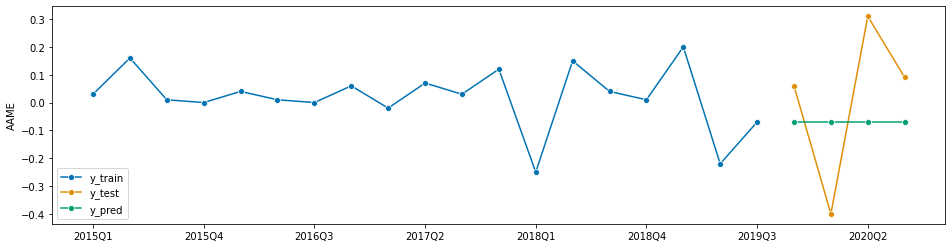

In [47]:
# using sktime naive
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

1.269219693589582

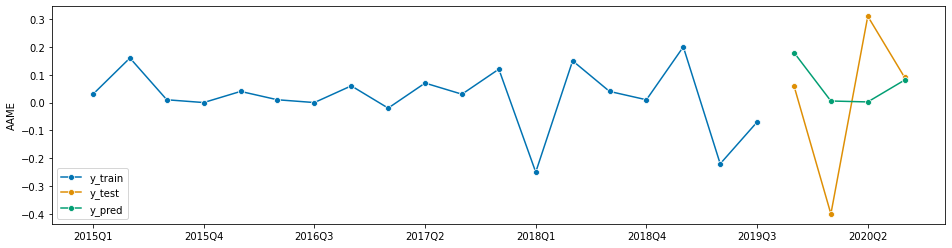

In [48]:
# using sktime arima
forecaster = ARIMA(order=(len(y_train)-1,2,0), suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

# Forecasting EPS and STD

In [49]:
def window(col, ord):
    # y_train_old = y_train.copy()
#     ord = 8
    # y_train = y_train_old
    y_new = pd.DataFrame()
    for i in range(ord+1):
        y_new = pd.concat([y_new, col.shift(i)], axis = 1)

    X= y_new.dropna()
    y = X.iloc[:,-1]
    X = X.iloc[:,:-1]
    return X,y

In [50]:
def old_method(col, ord):
    y_pred,std_window = [],[]
    X,y = window(col, ord)
    for idx,row in X.iterrows():
        lr = LinearRegression()
        lr.fit(np.arange(1,ord+1).reshape(-1,1), row)
        y_pred.append(lr.predict(y[idx].reshape(-1,1))[0])
        std_window.append(row.std())
#     print(f'y_pred:{y_pred},\nstd_window:{std_window}')
    return y_pred, std_window

# pred = pd.DataFrame(old_method(col,12), columns = col.index)

In [51]:
def eps_pred_std(df, ord):
    std_pred = {}
    pred = {}
    for row,col in df.iteritems():
        pred[row], std_pred[row] = old_method(col,ord)

    df_pred = pd.DataFrame.from_dict(data =pred, orient = 'index', columns=df.index[ord:])
    df_std = pd.DataFrame.from_dict(data =std_pred, orient = 'index', columns=df.index[ord:])
    return df_pred, df_std
df_pred , df_std = eps_pred_std(df, 12)

In [52]:
df_pred

index,2018-03-31,2018-06-30,2018-09-30,2018-12-31,2019-03-31,2019-06-30,2019-09-30,2019-12-31,2020-03-31,2020-06-30,2020-09-30
ZNOG,-0.063441,-0.053670,-0.030196,-0.184089,-0.155888,-0.133376,-0.104402,-0.073318,-0.049929,-0.035641,-0.010979
ZIVO,-0.024105,-0.026855,-0.030779,-0.025000,-0.024252,-0.021831,-0.017728,-0.013630,-0.009533,-0.002099,-0.000559
ZGNX,-2.283128,-1.008599,-1.282417,-1.039207,-0.905966,-0.849995,-2.881836,-2.713671,-2.209332,-1.910794,-1.883635
ZAGG,0.161067,0.193817,0.362403,0.520717,0.281007,0.164050,0.173435,0.365824,-0.663197,-0.645041,-0.480740
YEWB,-0.014754,-0.004877,-0.012197,-0.032553,-0.027780,-0.013705,-0.005123,-0.027262,-0.028939,0.014154,0.030541
...,...,...,...,...,...,...,...,...,...,...,...
ABMC,-0.006364,-0.005760,-0.006818,-0.009552,-0.010152,-0.006970,-0.005910,-0.006515,-0.006667,-0.005150,-0.005303
ABIO,-2.724683,-3.396105,-1.431635,1.472410,5.070052,7.338760,9.213294,8.736468,8.235220,6.501984,3.458363
ABEO,-0.176192,-0.208313,-0.273640,-0.327920,-0.383721,-0.468804,-0.461848,-0.452762,-0.499252,-0.419412,-0.302406
ABCP,-0.238168,-0.194787,-0.150262,-0.088893,-0.044883,-0.009401,0.034220,0.083475,0.126530,0.172342,-0.156555


In [53]:
df_std.head()

index,2018-03-31,2018-06-30,2018-09-30,2018-12-31,2019-03-31,2019-06-30,2019-09-30,2019-12-31,2020-03-31,2020-06-30,2020-09-30
ZNOG,0.032287,0.033575,0.039187,0.142028,0.142350,0.143590,0.144212,0.145193,0.146440,0.147114,0.147638
ZIVO,0.009045,0.009045,0.009847,0.008660,0.008348,0.008660,0.008660,0.008660,0.008660,0.009847,0.009962
ZGNX,1.379370,0.328491,0.327149,0.328255,0.294066,0.289697,1.694286,1.688918,1.701816,1.701024,1.702172
ZAGG,0.204871,0.204293,0.244516,0.274210,0.321653,0.328988,0.318237,0.370352,0.873820,0.873670,0.869338
YEWB,0.076925,0.076693,0.077004,0.079487,0.079368,0.079368,0.079368,0.079810,0.079810,0.050834,0.051316


In [54]:
df_pred.to_csv("../dataset/df_pred.csv", index = False)
df_std.to_csv("../dataset/df_std.csv", index=False)